In [1]:
import sys
sys.path.insert(0, "..")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IA.utils import mapping, parameter_range
from scipy import stats
import math
import swifter
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use(['science'])

In [5]:
df = pd.read_csv("analysis/not_uploaded/NIMA_test_dist.csv", sep=";")

In [6]:
df["dist"] = df["dist"].swifter.apply(eval)
df["score"] = df["dist"].swifter.apply(lambda row: sum([row[i] * (i+1) for i in range(len(row))]))
df = df.drop(columns=["dist"])

Pandas Apply: 100%|██████████| 2745000/2745000 [00:07<00:00, 353817.71it/s]


In [8]:
df = df.drop_duplicates()
df = df.dropna()

In [9]:
df["intensity"] = [float("nan")]*len(df)
df.loc[df["change"] == 0, "intensity"] = 0
for t in ["styles", "technical", "composition"]:
    for dist in mapping[t].keys():
        for pol in mapping[t][dist].keys():
            if pol == "neg":
                for lvl, change in enumerate(reversed(mapping[t][dist][pol])):
                    df.loc[(df["parameter"] == change.split(";")[0])&(df["change"] == float(change.split(";")[1])), "intensity"] = -(lvl+1)
            if pol == "pos":
                for lvl, change in enumerate(mapping[t][dist][pol]):
                    df.loc[(df["parameter"] == change.split(";")[0])&(df["change"] == float(change.split(";")[1])), "intensity"] = lvl+1
df["intensity"] = df["intensity"].astype(int)

df

,img,parameter,change,score,intensity
0,pexels-photo-2601199.jpeg,original,0.0,4.467532,0
1,pexels-photo-2281715.jpeg,original,0.0,4.806649,0
2,pexels-photo-1444107.jpeg,original,0.0,4.942514,0
3,pexels-photo-3326725.jpeg,original,0.0,5.139392,0
4,pexels-photo-2347378.jpeg,original,0.0,5.655336,0
...,...,...,...,...,...
2744995,pexels-photo-1228628.jpeg,ratio,5.0,5.365430,5
2744996,pexels-photo-2300895.jpeg,ratio,5.0,5.117791,5
2744997,pexels-photo-2704927.jpeg,ratio,5.0,5.496682,5
2744998,pexels-photo-1033922.jpeg,ratio,5.0,5.238024,5


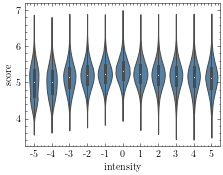

In [18]:
sns.violinplot(data=df[(df["parameter"] == "original") | (df["parameter"].isin(mapping["styles"].keys()))], x="intensity", y="score", color="steelblue")
plt.savefig("analysis/IA/score_one.pdf")

In [32]:
df[df["parameter"] == "original"]["score"].mean()

5.390061299099702

In [22]:
df[(df["parameter"] == "original") & (df["score"] > 5)]

,img,parameter,change,score,intensity
3,pexels-photo-3326725.jpeg,original,0.0,5.139392,0
4,pexels-photo-2347378.jpeg,original,0.0,5.655336,0
5,pexels-photo-2281410.jpeg,original,0.0,5.327895,0
6,pexels-photo-3372137.jpeg,original,0.0,5.504383,0
7,pexels-photo-3523939.jpeg,original,0.0,5.430642,0
...,...,...,...,...,...
2739535,pexels-photo-1228628.jpeg,original,0.0,5.625797,0
2739536,pexels-photo-2300895.jpeg,original,0.0,5.289550,0
2739537,pexels-photo-2704927.jpeg,original,0.0,6.019356,0
2739538,pexels-photo-1033922.jpeg,original,0.0,5.530634,0


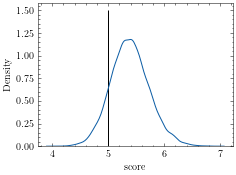

In [30]:
sns.kdeplot(df[df["parameter"] == "original"]["score"])
plt.vlines(5, ymin=0, ymax=1.5)
plt.savefig("analysis/score_dist.pdf")

In [6]:
pd.DataFrame(df[df["parameter"] != "original"][["img", "score"]].groupby("img").max().to_records()).sort_values("img")

,img,score
0,SW_Pamela%2BWebb.jpg,5.942276
1,abbey-glass-religion-architecture-106158.jpeg,6.183930
2,abraham-lincoln-lincoln-memorial-washington-dc...,6.575712
3,abstract-background-backgrounds-botany-87770.jpeg,5.857737
4,adler-bird-bird-of-prey-raptor-53587.jpeg,6.203509
...,...,...
14995,wood-painting-window-cactus-6689.jpg,6.217235
14996,wood-sky-forest-autumn.jpg,6.609596
14997,wood-stool-wooden-wine.jpg,6.671277
14998,wood-tree-brown-bark.jpg,6.552022


In [8]:
df[df["parameter"] == "original"][["img", "score"]].sort_values("img").reset_index()

,index,img,score
0,16497,SW_Pamela%2BWebb.jpg,5.469148
1,1542691,abbey-glass-religion-architecture-106158.jpeg,5.795786
2,2025835,abraham-lincoln-lincoln-memorial-washington-dc...,5.037946
3,269016,abstract-background-backgrounds-botany-87770.jpeg,5.633471
4,1592124,adler-bird-bird-of-prey-raptor-53587.jpeg,5.515703
...,...,...,...
14995,203158,wood-painting-window-cactus-6689.jpg,5.614739
14996,1317604,wood-sky-forest-autumn.jpg,5.555734
14997,581961,wood-stool-wooden-wine.jpg,5.420850
14998,472144,wood-tree-brown-bark.jpg,5.360961


In [10]:
# & (df["parameter"] != "pixelate") & (df["parameter"] != "impulse_noise")
scores = pd.DataFrame(df[(df["parameter"] != "original")][["img", "score"]].groupby("img").max().to_records()).sort_values("img").rename(columns={"score":"best_score"})
scores["orig_score"] = df[df["parameter"] == "original"][["img", "score"]].sort_values("img").reset_index()["score"]
scores["diff"] = scores["orig_score"] - scores["best_score"]
scores

,img,best_score,orig_score,diff
0,SW_Pamela%2BWebb.jpg,5.942276,5.469148,-0.473127
1,abbey-glass-religion-architecture-106158.jpeg,6.183930,5.795786,-0.388144
2,abraham-lincoln-lincoln-memorial-washington-dc...,6.575712,5.037946,-1.537766
3,abstract-background-backgrounds-botany-87770.jpeg,5.857737,5.633471,-0.224265
4,adler-bird-bird-of-prey-raptor-53587.jpeg,6.203509,5.515703,-0.687807
...,...,...,...,...
14995,wood-painting-window-cactus-6689.jpg,6.217235,5.614739,-0.602496
14996,wood-sky-forest-autumn.jpg,6.609596,5.555734,-1.053861
14997,wood-stool-wooden-wine.jpg,6.671277,5.420850,-1.250427
14998,wood-tree-brown-bark.jpg,6.552022,5.360961,-1.191062


In [12]:
scores.nlargest(10, "diff")

,img,best_score,orig_score,diff
4599,pexels-photo-1769328.jpeg,6.544458,6.556608,0.012150
11175,pexels-photo-3329728.jpeg,6.243080,6.215960,-0.027119
1926,pexels-photo-1229845.jpeg,6.207047,6.171796,-0.035251
4189,pexels-photo-1684996.jpeg,6.408931,6.369301,-0.039630
4588,pexels-photo-176851.jpeg,6.216792,6.161009,-0.055783
7016,pexels-photo-2301527.jpeg,6.328324,6.270555,-0.057769
10510,pexels-photo-3137054.jpeg,5.872587,5.814739,-0.057848
2469,pexels-photo-1341279.jpeg,6.190482,6.128958,-0.061524
12177,pexels-photo-367903.jpeg,6.329517,6.265786,-0.063731
2444,pexels-photo-1335971.jpeg,6.210132,6.142366,-0.067766


In [14]:
scores.nsmallest(10, "diff")

,img,best_score,orig_score,diff
3277,pexels-photo-1516901.jpeg,6.620496,4.353921,-2.266576
1858,pexels-photo-1212612.jpeg,6.433586,4.203651,-2.229935
8688,pexels-photo-2674271.jpeg,6.525705,4.361502,-2.164202
7381,pexels-photo-2376411.jpeg,6.463999,4.315790,-2.148209
11804,pexels-photo-3570079.jpeg,6.407996,4.277341,-2.130655
1519,pexels-photo-1149017.jpeg,6.735572,4.624091,-2.111482
4018,pexels-photo-1662242.jpeg,6.828757,4.721621,-2.107136
13531,pexels-photo-761362.jpeg,6.560960,4.458374,-2.102586
4928,pexels-photo-1844241.jpeg,6.581505,4.483325,-2.098180
6864,pexels-photo-2267157.jpeg,6.579521,4.484919,-2.094603


In [16]:
nsmall = []
for i, row in scores.nsmallest(10, "diff").iterrows():
    nsmall.append(df[(df["img"] == row.img) & (df["score"] == row.best_score)])
pd.concat(nsmall)

,img,parameter,change,dist,score
2605815,pexels-photo-1516901.jpeg,impulse_noise,1.0,"[0.0038463992532342672, 0.00031068146927282214...",6.620496
332665,pexels-photo-1212612.jpeg,pixelate,1.0,"[0.0021706291008740664, 8.962512947618961e-05,...",6.433586
1414473,pexels-photo-2674271.jpeg,impulse_noise,1.0,"[0.003357598325237632, 0.00043243003892712295,...",6.525705
1068313,pexels-photo-2376411.jpeg,pixelate,1.0,"[0.0016660054679960012, 7.721801375737414e-05,...",6.463999
2594839,pexels-photo-3570079.jpeg,impulse_noise,1.0,"[0.004496151581406593, 0.0005054007051512599, ...",6.407996
85909,pexels-photo-1149017.jpeg,impulse_noise,1.0,"[0.002972234506160021, 0.00012827372120227665,...",6.735572
1814966,pexels-photo-1662242.jpeg,pixelate,1.0,"[0.0003622239164542407, 2.8703386760753347e-06...",6.828757
2462791,pexels-photo-761362.jpeg,pixelate,2.0,"[0.0017913879128172994, 5.147826232132502e-05,...",6.560960
2106238,pexels-photo-1844241.jpeg,impulse_noise,1.0,"[0.0033306623809039593, 0.0005150048527866602,...",6.581505
2210532,pexels-photo-2267157.jpeg,impulse_noise,1.0,"[0.003698816057294607, 0.0004565923591144383, ...",6.579521


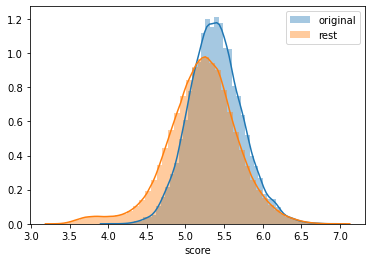

In [18]:
sns.distplot(df[df["parameter"] == "original"]["score"], label="original")
sns.distplot(df[df["parameter"] != "original"]["score"], label="rest")
plt.legend()

In [20]:
def histogram_distortion(distortion:str):
    sns.distplot(df[df["parameter"] == "original"]["score"], label="original")
    for change in (val for val in mapping["all_changes"] if distortion in val):
        parameter, change = change.split(";")
        sns.distplot(df[(df["parameter"] == parameter) & (df["change"] == float(change))]["score"], label=f"{parameter}: {change}")
    plt.legend()

In [22]:
def violin_distortion(distortion:str): # FIXME defaults for shadows, hightlights...
    plot_frame = df[(df["parameter"] == distortion) | (df["parameter"] == "original")]
    if distortion in parameter_range:
        plot_frame.loc[plot_frame["parameter"] == "original", "change"] = parameter_range[distortion]["default"]
    sns.violinplot(data=plot_frame, x="change", y="score", color="steelblue")

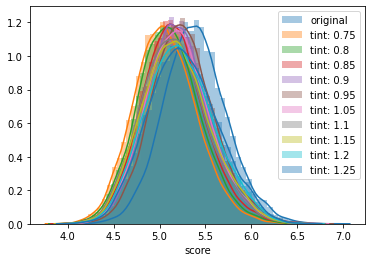

In [24]:
histogram_distortion("tint")

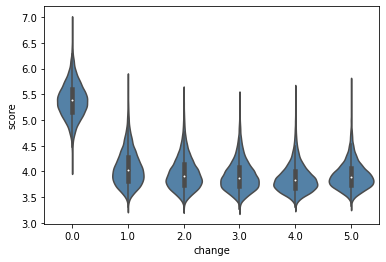

In [26]:
violin_distortion("jpeg_compression")

In [53]:
def calculate_spearman(distortion:str, polarity:str, img_names=df["img"].unique()):
    corr_l = []
    p_l = []
    for i, f in enumerate(img_names):
        print(f"{i}/{len(img_names)}")
        corr_df = df[(df["img"] == f) & ((df["parameter"] == distortion) | (df["parameter"] == "original"))]
        del corr_df["dist"]
        if distortion in parameter_range:
            corr_df.loc[corr_df["parameter"] == "original", "change"] = parameter_range[distortion]["default"]

        if distortion in parameter_range:
            if polarity == "pos":
                corr_df = corr_df[corr_df["change"] >= parameter_range[distortion]["default"]]
            else:
                corr_df = corr_df[corr_df["change"] <= parameter_range[distortion]["default"]]
            rel_change = [-abs((val) - (parameter_range[distortion]["default"])) for val in corr_df["change"]]
        else:
            if polarity == "pos":
                corr_df = corr_df[corr_df["change"] >= 0]
            else:
                corr_df = corr_df[corr_df["change"] <= 0]
            rel_change = [-val for val in corr_df["change"]]
        c, p = stats.spearmanr(corr_df["score"], rel_change)
        corr_l.append(c)
        p_l.append(p)
    return sum(corr_l)/len(corr_l), sum(p_l)/len(p_l)

In [52]:
calculate_spearman("jpeg_compression", polarity="pos")

0/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
1/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
2/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
3/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
4/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
5/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
6/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
7/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
8/15000
Index(['img', 'parameter', 'change', 'score'], dtype='object')
9/15000


KeyboardInterrupt: 

In [38]:
del parameter_range["jpeg_compression"]
parameter_range.keys()

dict_keys(['contrast', 'brightness', 'saturation', 'shadows', 'highlights', 'exposure', 'vibrance', 'temperature', 'tint', 'lcontrast'])